In [1]:
# Author: Carla Becker, carlabecker@berkeley.edu
# Adapted from code by Tarek Zohdi, zohdi@berkeley.edu

import numpy as np
import matplotlib.pyplot as plt
import math
import os
import time
import matplotlib.animation as animation
import mpl_toolkits.mplot3d as a3
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
from scipy.spatial import ConvexHull

plt.rcParams['animation.embed_limit'] = 2**128
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern Roman",
})

# Python on Desktop (Mac OS instructions)
# Download the latest stable release of FFMPEG at the link below
# https://www.ffmpeg.org/download.html
# Unzip the file and save it in your working directory
# In the terminal, type
# export PATH=$PATH:.

# Jupyter Notebook
# Uncomment the line below
from IPython.display import HTML

In [2]:
#------------------------------------------------------------------#
# Boolean Constants
#------------------------------------------------------------------#
movie = True

rack_X1_X3 = True 
rack_X2_X3 = True 
rack_X1_X2 = True

X1_minus_on = True 
X1_plus_on  = True 
X2_minus_on = True 
X2_plus_on  = True 
X3_minus_on = True 
X3_plus_on  = True

In [3]:
#------------------------------------------------------------------#
# Double/Integer Constants
#------------------------------------------------------------------#
nsteps = 100 # number of time steps
vlight0 = 299792458.0
raydensity = 1.0e1
ray_TOL = 1.0e-6
xdist_TOL = 1.0e-8

# Pod Dimensions (in meters)
pod_X1 = 6
pod_X2 = 1
pod_X3 = 1

# Targets
ntargets_X1 = 9
ntargets_X2 = 3
ntargets_X3 = 3

R1 = 0.05 # ellipsoidal plant radius in X1, [m]
R2 = 0.05 # ellipsoidal plant radius in X2, [m]
R3 = 0.05 # ellipsoidal plant radius in X3, [m]

p1 = 6.0 # ellipsoidal plant exponent in X1, []
p2 = 6.0 # ellipsoidal plant exponent in X1, []
p3 = 6.0 # ellipsoidal plant exponent in X1, []

if (2 * ntargets_X1 * 2 * R1) > pod_X1 or \
   (2 * ntargets_X2 * 2 * R2) > pod_X2 or \
   (2 * ntargets_X3 * 2 * R3) > pod_X3:
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print("STOP! Too many targets or targets too big!")
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

# Spatial and Time Resolution
delta_X1 = 0.05 
delta_X2 = 0.05 
delta_X3 = 0.05

delta_t = (delta_X1 + delta_X2 + delta_X3) / (3 * vlight0)

# Source Tube
for_plus_X1_sourcetube_X2  = 0.5 # sourcetube for +X1 rays, dim in X2, [m]
for_plus_X1_sourcetube_X3  = 0.5 # sourcetube for +X1 rays, dim in X3, [m]
for_minus_X1_sourcetube_X2 = 0.5 # sourcetube for -X1 rays, dim in X2, [m]
for_minus_X1_sourcetube_X3 = 0.5 # sourcetube for -X1 rays, dim in X3, [m]

for_plus_X2_sourcetube_X1  = 3.0 # sourcetube for +X2 rays, dim in X1, [m]
for_plus_X2_sourcetube_X3  = 0.5 # sourcetube for +X2 rays, dim in X3, [m]
for_minus_X2_sourcetube_X1 = 3.0 # sourcetube for -X2 rays, dim in X1, [m]
for_minus_X2_sourcetube_X3 = 0.5 # sourcetube for -X2 rays, dim in X3, [m]

for_plus_X3_sourcetube_X1  = 3.0 # sourcetube for +X3 rays, dim in X1, [m]
for_plus_X3_sourcetube_X2  = 0.5 # sourcetube for +X3 rays, dim in X2, [m]
for_minus_X3_sourcetube_X1 = 3.0 # sourcetube for -X3 rays, dim in X1, [m]
for_minus_X3_sourcetube_X2 = 0.5 # sourcetube for -X3 rays, dim in X2, [m]

# Wall and Target Material Properties
nhat_wall = 10.0
nhat_gnd = 10.0
nhat_tar = 2.0

uhat_wall = 1.0
uhat_gnd = 1.0
uhat_tar = 1.0

# Total Power Coming from LEDs on each Wall
total_face_power_X1_minus = 1.0e7
total_face_power_X1_plus  = 1.0e7

total_face_power_X2_minus = 1.0e7
total_face_power_X2_plus  = 1.0e7

total_face_power_X3_minus = 1.0e7
total_face_power_X3_plus  = 1.0e7


In [4]:
#------------------------------------------------------------------#
# Constants from Genetic String
#------------------------------------------------------------------#

# Aperature
A1  = 0.01 
A2  = 0.01 
A3  = 0.01 
A4  = 0.01 
A5  = 0.01 
A6  = 0.01 
A7  = 0.01 
A8  = 0.01 
A9  = 0.01 
A10 = 0.01 
A11 = 0.01 
A12 = 0.01 
A13 = 0.01 
A14 = 0.01 
A15 = 0.01 
A16 = 0.01 
A17 = 0.01 
A18 = 0.01 

In [5]:
#------------------------------------------------------------------#
# Calculated Constants
#------------------------------------------------------------------#

# Target Spacing and Total Targets
tar_spacing_X1 = (1/2 * pod_X1 - (ntargets_X1 + 1) * 2*R1) / (ntargets_X1 + 1)
tar_spacing_X2 = (1/2 * pod_X2 - (ntargets_X2 + 1) * 2*R2) / (ntargets_X2 + 1)
tar_spacing_X3 = (1/2 * pod_X3 - (ntargets_X3 + 1) * 2*R3) / (ntargets_X3 + 1)

tar_delta_X1 = 2 * R1 + tar_spacing_X1
tar_delta_X2 = 2 * R2 + tar_spacing_X2
tar_delta_X3 = 2 * R3 + tar_spacing_X3

ntargets = 2*ntargets_X1 * 2*ntargets_X2 + \
           2*ntargets_X1 * 2*ntargets_X3 + \
           2*ntargets_X2 * 2*ntargets_X3

# Number of Rays Propagating in Each Direction
nrays_plus_X1  = int(raydensity * 2 * for_plus_X1_sourcetube_X2  * 2 * for_plus_X1_sourcetube_X3)
nrays_minus_X1 = int(raydensity * 2 * for_minus_X1_sourcetube_X2 * 2 * for_minus_X1_sourcetube_X3)

nrays_plus_X2  = int(raydensity * 2 * for_plus_X2_sourcetube_X1  * 2 * for_plus_X2_sourcetube_X3)
nrays_minus_X2 = int(raydensity * 2 * for_minus_X2_sourcetube_X1 * 2 * for_minus_X2_sourcetube_X3)

nrays_plus_X3  = int(raydensity * 2 * for_plus_X3_sourcetube_X1  * 2 * for_plus_X3_sourcetube_X2)
nrays_minus_X3 = int(raydensity * 2 * for_minus_X3_sourcetube_X1 * 2 * for_minus_X3_sourcetube_X2)

nrays = nrays_plus_X1 + nrays_minus_X1 + \
        nrays_plus_X2 + nrays_minus_X2 + \
        nrays_plus_X3 + nrays_minus_X3
nrays = int(nrays)

print("# of rays in +X1: ", nrays_plus_X1)
print("# of rays in -X1: ", nrays_minus_X1)
print("# of rays in +X2: ", nrays_plus_X2)
print("# of rays in -X2: ", nrays_minus_X2)
print("# of rays in +X3: ", nrays_plus_X3)
print("# of rays in -X3: ", nrays_minus_X3)
print("TOTAL RAYS: ", nrays)

# Reflection Data
wall_X1_minus_cutoff = -pod_X1/2
wall_X1_plus_cutoff  =  pod_X1/2

wall_X2_minus_cutoff = -pod_X2/2
wall_X2_plus_cutoff  =  pod_X2/2

wall_X3_minus_cutoff = -pod_X3/2
wall_X3_plus_cutoff  =  pod_X3/2

# Power per ray traveling in each direction
irrad_X1_minus = total_face_power_X1_minus / nrays_minus_X1
irrad_X1_plus  = total_face_power_X1_plus  / nrays_plus_X1

irrad_X2_minus = total_face_power_X2_minus / nrays_minus_X2
irrad_X2_plus  = total_face_power_X2_plus  / nrays_plus_X2

irrad_X3_minus = total_face_power_X3_minus / nrays_minus_X3
irrad_X3_plus  = total_face_power_X3_plus  / nrays_plus_X3

# of rays in +X1:  10
# of rays in -X1:  10
# of rays in +X2:  60
# of rays in -X2:  60
# of rays in +X3:  60
# of rays in -X3:  60
TOTAL RAYS:  260


In [6]:
#------------------------------------------------------------------#
# Helper Functions
#------------------------------------------------------------------#

def get_irradiance(thetai, nhat, uhat):

    # Calculate power in perpendicular (per) and parallel (par) polarizations
    if abs(np.sin(thetai))/nhat > 1.0: # should not be possible by Snell's Law...
        rper = 1.0
        rpar = 1.0
    else:
        rper = (np.cos(thetai) - 1/uhat * (nhat**2 - np.sin(thetai)**2)**0.5) / \
               (np.cos(thetai) + 1/uhat * (nhat**2 - np.sin(thetai)**2)**0.5)

        rpar = (nhat**2/uhat * np.cos(thetai) - (nhat**2 - np.sin(thetai)**2)**0.5) / \
               (nhat**2/uhat * np.cos(thetai) + (nhat**2 - np.sin(thetai)**2)**0.5)

    # Reflectivities
    big_rpar = rpar**2
    big_rper = rper**2
    IR = 0.5 * (big_rpar + big_rper)

    return IR

def get_wall_normals(ir):

    # Walls (6 walls: top, bottom, front, back, left, right)
    if rlight_X1[ir] >= wall_X1_plus_cutoff:
        nX1 = -1.0
        nX2 =  0.0
        nX3 =  0.0
    elif rlight_X1[ir] <= wall_X1_minus_cutoff:
        nX1 =  1.0
        nX2 =  0.0
        nX3 =  0.0
    elif rlight_X2[ir] >= wall_X2_plus_cutoff:
        nX1 =  0.0
        nX2 = -1.0
        nX3 =  0.0
    elif rlight_X2[ir] <= wall_X2_minus_cutoff:
        nX1 =  0.0
        nX2 =  1.0
        nX3 =  0.0
    elif rlight_X3[ir] >= wall_X3_plus_cutoff:
        nX1 =  0.0
        nX2 =  0.0
        nX3 = -1.0
    elif rlight_X3[ir] <= wall_X3_minus_cutoff:
        nX1 =  0.0
        nX2 =  0.0
        nX3 =  1.0
                    
    return nX1, nX2, nX3

def get_rect_pc(center, dims, facecolor, edgecolor, alpha):

    # Get the 3D polygon collection (pc) that will define the rectangular prism with dimensions x1_dim * x2_dim * x3_dim
    c1 = center[0]
    c2 = center[1]
    c3 = center[2]

    x1_dim = dims[0]
    x2_dim = dims[1]
    x3_dim = dims[2]
    
    x1 = np.array([x1_dim,  x1_dim, -x1_dim, -x1_dim,  x1_dim,  x1_dim, -x1_dim, -x1_dim])/2 + c1
    x2 = np.array([x2_dim, -x2_dim, -x2_dim,  x2_dim,  x2_dim, -x2_dim, -x2_dim,  x2_dim])/2 + c2
    x3 = np.array([x3_dim,  x3_dim,  x3_dim,  x3_dim, -x3_dim, -x3_dim, -x3_dim, -x3_dim])/2 + c3

    vertices = np.c_[x1, x2, x3]
    hull = ConvexHull(vertices) # compute the triangles that make up the convex hull of the rect prism
    triangles = [vertices[s] for s in hull.simplices]
    faces = Faces(triangles, sig_dig=1).simplify() # combine co-planar triangles into a single face

    rect_prism_pc = a3.art3d.Poly3DCollection(faces, facecolor=facecolor, edgecolor=edgecolor, alpha=alpha)
    return rect_prism_pc

# From https://stackoverflow.com/questions/53816211/plot-3d-connected-prism-matplotlib-based-on-vertices
class Faces():
    def __init__(self,tri, sig_dig=12, method="convexhull"):
        self.method=method
        self.tri = np.around(np.array(tri), sig_dig)
        self.grpinx = list(range(len(tri)))
        norms = np.around([self.norm(s) for s in self.tri], sig_dig)
        _, self.inv = np.unique(norms,return_inverse=True, axis=0)

    def norm(self,sq):
        cr = np.cross(sq[2]-sq[0],sq[1]-sq[0])
        return np.abs(cr/np.linalg.norm(cr))

    def isneighbor(self, tr1,tr2):
        a = np.concatenate((tr1,tr2), axis=0)
        return len(a) == len(np.unique(a, axis=0))+2

    def order(self, v):
        if len(v) <= 3:
            return v
        v = np.unique(v, axis=0)
        n = self.norm(v[:3])
        y = np.cross(n,v[1]-v[0])
        y = y/np.linalg.norm(y)
        c = np.dot(v, np.c_[v[1]-v[0],y])
        if self.method == "convexhull":
            h = ConvexHull(c)
            return v[h.vertices]
        else:
            mean = np.mean(c,axis=0)
            d = c-mean
            s = np.arctan2(d[:,0], d[:,1])
            return v[np.argsort(s)]

    def simplify(self):
        for i, tri1 in enumerate(self.tri):
            for j,tri2 in enumerate(self.tri):
                if j > i:
                    if self.isneighbor(tri1,tri2) and \
                       self.inv[i]==self.inv[j]:
                        self.grpinx[j] = self.grpinx[i]
        groups = []
        for i in np.unique(self.grpinx):
            u = self.tri[self.grpinx == i]
            u = np.concatenate([d for d in u])
            u = self.order(u)
            groups.append(u)
        return groups

In [7]:
#------------------------------------------------------------------#
# Initialize and Enumerate Targets (Plant Racks)
#------------------------------------------------------------------#

# Initialize Variables
count = 0 # count will go from 0 to ntargets
target_absorb = np.zeros(ntargets)
target_X1 = np.zeros(ntargets) 
target_X2 = np.zeros(ntargets) 
target_X3 = np.zeros(ntargets) 

# Target 1
if rack_X2_X3:
    i1 = 0
    X1 = 0
    for i2 in range(-ntargets_X2, ntargets_X2+1):
        if i2==0: continue
        X2 = tar_delta_X2 * i2
        for i3 in range(-ntargets_X3, ntargets_X3+1):
            if i3==0: continue
            X3 = tar_delta_X3 * i3
            target_X1[count] = X1
            target_X2[count] = X2
            target_X3[count] = X3
            target_absorb[count] = 0.0
            count = count + 1

# Target 2
if rack_X1_X3:
    i2 = 0
    X2 = 0
    for i1 in range(-ntargets_X1, ntargets_X1+1):
        if i1==0: continue
        X1 = tar_delta_X1 * i1
        for i3 in range(-ntargets_X3, ntargets_X3+1):
            if i3==0: continue
            X3 = tar_delta_X3 * i3
            target_X1[count] = X1
            target_X2[count] = X2
            target_X3[count] = X3
            target_absorb[count] = 0.0
            count = count + 1

# Target 3
if rack_X1_X2:
    i3 = 0
    X3 = 0
    for i1 in range(-ntargets_X1, ntargets_X1+1):
        if i1==0: continue
        X1 = tar_delta_X1 * i1
        for i2 in range(-ntargets_X2, ntargets_X2+1):
            if i2==0: continue
            X2 = tar_delta_X2 * i2
            target_X1[count] = X1
            target_X2[count] = X2
            target_X3[count] = X3
            target_absorb[count] = 0.0
            count = count + 1

In [8]:
#------------------------------------------------------------------#
# Initialize Ray Directions and Velocities
#------------------------------------------------------------------#

# Initialization
tflag = np.zeros(nrays)

irrad = np.zeros(nrays)
irrad0 = np.zeros(nrays)

rlight_X1 = np.zeros(nrays)
rlight_X2 = np.zeros(nrays)
rlight_X3 = np.zeros(nrays)

vlight_X1 = np.zeros(nrays)
vlight_X2 = np.zeros(nrays)
vlight_X3 = np.zeros(nrays)

power_X1 = np.zeros(nrays)
power_X2 = np.zeros(nrays)
power_X3 = np.zeros(nrays)

ray_count = 0 # ray_count will range from 0 to nrays

for_minus_X1 = np.zeros((nrays_minus_X1, 3)) # 3 for the 3 dimensions: X1, X2, X3
for_plus_X1  = np.zeros((nrays_plus_X1,  3))
for_minus_X2 = np.zeros((nrays_minus_X2, 3))
for_plus_X2  = np.zeros((nrays_plus_X2,  3))
for_minus_X3 = np.zeros((nrays_minus_X3, 3))
for_plus_X3  = np.zeros((nrays_plus_X3,  3))

# -X1 direction
start = 0
end = nrays_minus_X1
if X1_minus_on:
    for ir in range(start, end):
        irrad[ray_count] = irrad_X1_minus
        irrad0[ray_count] = irrad_X1_minus

        rlight_X1[ray_count] = wall_X1_plus_cutoff - delta_X1
        rlight_X2[ray_count] = np.random.uniform(wall_X2_minus_cutoff + delta_X2, wall_X2_plus_cutoff - delta_X2)
        rlight_X3[ray_count] = np.random.uniform(wall_X3_minus_cutoff + delta_X3, wall_X3_plus_cutoff - delta_X3)

        aperature_X1 = np.random.uniform(0, A1)
        aperature_X2 = np.random.uniform(0, A2)
        aperature_X3 = np.random.uniform(0, A3)

        aperature_mag = np.sqrt(aperature_X1**2 + aperature_X2**2 + aperature_X3**2)
        norm_X1 = -aperature_X1 / aperature_mag # negative sign right?
        norm_X2 =  aperature_X2 / aperature_mag
        norm_X3 =  aperature_X3 / aperature_mag

        vlight_X1[ray_count] = norm_X1 * vlight0
        vlight_X2[ray_count] = norm_X2 * vlight0
        vlight_X3[ray_count] = norm_X3 * vlight0

        power_X1[ray_count] = irrad[ray_count] * norm_X1
        power_X2[ray_count] = irrad[ray_count] * norm_X2
        power_X3[ray_count] = irrad[ray_count] * norm_X3
        
        ray_count = ray_count + 1

# +X1 direction
start = end
end = end + nrays_plus_X1
if X1_plus_on:
    for ir in range(start, end):
        irrad[ray_count] = irrad_X1_plus
        irrad0[ray_count] = irrad_X1_plus

        rlight_X1[ray_count] = wall_X1_minus_cutoff + delta_X1
        rlight_X2[ray_count] = np.random.uniform(wall_X2_minus_cutoff + delta_X2, wall_X2_plus_cutoff - delta_X2)
        rlight_X3[ray_count] = np.random.uniform(wall_X3_minus_cutoff + delta_X3, wall_X3_plus_cutoff - delta_X3)

        aperature_X1 = np.random.uniform(0, A4)
        aperature_X2 = np.random.uniform(0, A5)
        aperature_X3 = np.random.uniform(0, A6)

        aperature_mag = np.sqrt(aperature_X1**2 + aperature_X2**2 + aperature_X3**2)
        norm_X1 = aperature_X1 / aperature_mag
        norm_X2 = aperature_X2 / aperature_mag
        norm_X3 = aperature_X3 / aperature_mag

        vlight_X1[ray_count] = norm_X1 * vlight0 
        vlight_X2[ray_count] = norm_X2 * vlight0
        vlight_X3[ray_count] = norm_X3 * vlight0

        power_X1[ray_count] = irrad[ray_count] * norm_X1
        power_X2[ray_count] = irrad[ray_count] * norm_X2
        power_X3[ray_count] = irrad[ray_count] * norm_X3
        
        ray_count = ray_count + 1
        
# -X2 direction
start = end
end = end + nrays_minus_X2
if X2_minus_on:
    for ir in range(start, end):
        irrad[ray_count] = irrad_X2_minus
        irrad0[ray_count] = irrad_X2_minus

        rlight_X1[ray_count] = np.random.uniform(wall_X1_minus_cutoff + delta_X1, wall_X1_plus_cutoff - delta_X1)
        rlight_X2[ray_count] = wall_X2_plus_cutoff - delta_X2
        rlight_X3[ray_count] = np.random.uniform(wall_X3_minus_cutoff + delta_X3, wall_X3_plus_cutoff - delta_X3)

        aperature_X1 = np.random.uniform(0, A7)
        aperature_X2 = np.random.uniform(0, A8)
        aperature_X3 = np.random.uniform(0, A9)

        aperature_mag = np.sqrt(aperature_X1**2 + aperature_X2**2 + aperature_X3**2)
        norm_X1 =  aperature_X1 / aperature_mag
        norm_X2 = -aperature_X2 / aperature_mag # negative sign right?
        norm_X3 =  aperature_X3 / aperature_mag

        vlight_X1[ray_count] = norm_X1 * vlight0 
        vlight_X2[ray_count] = norm_X2 * vlight0
        vlight_X3[ray_count] = norm_X3 * vlight0

        power_X1[ray_count] = irrad[ray_count] * norm_X1
        power_X2[ray_count] = irrad[ray_count] * norm_X2
        power_X3[ray_count] = irrad[ray_count] * norm_X3

        ray_count = ray_count + 1

# +X2 direction
start = end
end = end + nrays_plus_X2
if X2_plus_on:
    for ir in range(start, end):
        irrad[ray_count] = irrad_X2_plus
        irrad0[ray_count] = irrad_X2_plus

        rlight_X1[ray_count] = np.random.uniform(wall_X1_minus_cutoff + delta_X1, wall_X1_plus_cutoff - delta_X1)
        rlight_X2[ray_count] = wall_X2_minus_cutoff + delta_X2
        rlight_X3[ray_count] = np.random.uniform(wall_X3_minus_cutoff + delta_X3, wall_X3_plus_cutoff - delta_X3)

        aperature_X1 = np.random.uniform(0, A10)
        aperature_X2 = np.random.uniform(0, A11)
        aperature_X3 = np.random.uniform(0, A12)

        aperature_mag = np.sqrt(aperature_X1**2 + aperature_X2**2 + aperature_X3**2)
        norm_X1 = aperature_X1 / aperature_mag
        norm_X2 = aperature_X2 / aperature_mag 
        norm_X3 = aperature_X3 / aperature_mag

        vlight_X1[ray_count] = norm_X1 * vlight0 
        vlight_X2[ray_count] = norm_X2 * vlight0
        vlight_X3[ray_count] = norm_X3 * vlight0

        power_X1[ray_count] = irrad[ray_count] * norm_X1
        power_X2[ray_count] = irrad[ray_count] * norm_X2
        power_X3[ray_count] = irrad[ray_count] * norm_X3

        ray_count = ray_count + 1

# -X3 direction
start = end
end = end + nrays_minus_X3
if X3_minus_on:
    for ir in range(start, end):
        irrad[ray_count] = irrad_X3_minus
        irrad0[ray_count] = irrad_X3_minus

        rlight_X1[ray_count] = np.random.uniform(wall_X1_minus_cutoff + delta_X1, wall_X1_plus_cutoff - delta_X1)
        rlight_X2[ray_count] = np.random.uniform(wall_X2_minus_cutoff + delta_X2, wall_X2_plus_cutoff - delta_X2)
        rlight_X3[ray_count] = wall_X3_plus_cutoff - delta_X3

        aperature_X1 = np.random.uniform(0, A13)
        aperature_X2 = np.random.uniform(0, A14)
        aperature_X3 = np.random.uniform(0, A15)

        aperature_mag = np.sqrt(aperature_X1**2 + aperature_X2**2 + aperature_X3**2)
        norm_X1 =  aperature_X1 / aperature_mag
        norm_X2 =  aperature_X2 / aperature_mag 
        norm_X3 = -aperature_X3 / aperature_mag # negative sign?

        vlight_X1[ray_count] = norm_X1 * vlight0 
        vlight_X2[ray_count] = norm_X2 * vlight0
        vlight_X3[ray_count] = norm_X3 * vlight0

        power_X1[ray_count] = irrad[ray_count] * norm_X1
        power_X2[ray_count] = irrad[ray_count] * norm_X2
        power_X3[ray_count] = irrad[ray_count] * norm_X3

        ray_count = ray_count + 1

# +X3 direction
start = end
end = end + nrays_plus_X3
if X3_plus_on:
    for ir in range(start, end):
        irrad[ray_count] = irrad_X3_plus
        irrad0[ray_count] = irrad_X3_plus

        rlight_X1[ray_count] = np.random.uniform(wall_X1_minus_cutoff + delta_X1, wall_X1_plus_cutoff - delta_X1)
        rlight_X2[ray_count] = np.random.uniform(wall_X2_minus_cutoff + delta_X2, wall_X2_plus_cutoff - delta_X2)
        rlight_X3[ray_count] = wall_X3_minus_cutoff + delta_X3

        aperature_X1 = np.random.uniform(0, A16)
        aperature_X2 = np.random.uniform(0, A17)
        aperature_X3 = np.random.uniform(0, A18)

        aperature_mag = np.sqrt(aperature_X1**2 + aperature_X2**2 + aperature_X3**2)
        norm_X1 = aperature_X1 / aperature_mag
        norm_X2 = aperature_X2 / aperature_mag 
        norm_X3 = aperature_X3 / aperature_mag

        vlight_X1[ray_count] = norm_X1 * vlight0 
        vlight_X2[ray_count] = norm_X2 * vlight0
        vlight_X3[ray_count] = norm_X3 * vlight0

        power_X1[ray_count] = irrad[ray_count] * norm_X1
        power_X2[ray_count] = irrad[ray_count] * norm_X2
        power_X3[ray_count] = irrad[ray_count] * norm_X3

        ray_count = ray_count + 1

0  of  100
0  of  100
1  of  100
2  of  100
3  of  100
4  of  100
5  of  100
6  of  100
7  of  100
8  of  100
9  of  100
10  of  100
11  of  100
12  of  100
13  of  100
14  of  100
15  of  100
16  of  100
17  of  100
18  of  100
19  of  100
20  of  100
21  of  100
22  of  100
23  of  100
24  of  100
25  of  100
26  of  100
27  of  100
28  of  100
29  of  100
30  of  100
31  of  100
32  of  100
33  of  100
34  of  100
35  of  100
36  of  100
37  of  100
38  of  100
39  of  100
40  of  100
41  of  100
42  of  100
43  of  100
44  of  100
45  of  100
46  of  100
47  of  100
48  of  100
49  of  100
50  of  100
51  of  100
52  of  100
53  of  100
54  of  100
55  of  100
56  of  100
57  of  100
58  of  100
59  of  100
60  of  100
61  of  100
62  of  100
63  of  100
64  of  100
65  of  100
66  of  100
67  of  100
68  of  100
69  of  100
70  of  100
71  of  100
72  of  100
73  of  100
74  of  100
75  of  100
76  of  100
77  of  100
78  of  100
79  of  100
80  of  100
81  of  100
82  of  100
83 

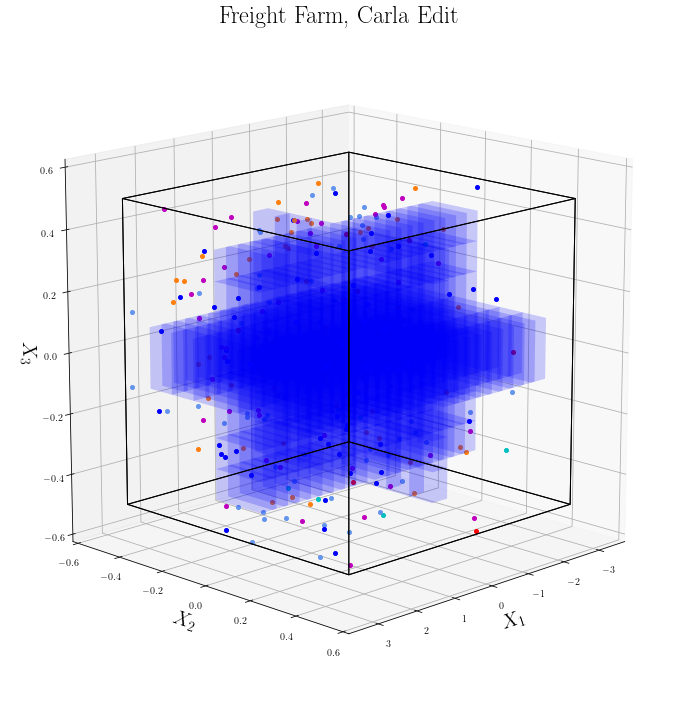

In [9]:
#------------------------------------------------------------------#
# Time-Stepping - Propagate the Light Rays
#------------------------------------------------------------------#
def update(n):  # Function to create plot

    sim_time = delta_t * n
    #print(sim_time)
    print(n, " of ", nsteps)

    # Check the position of each ray -- has it hit a wall or target?
    for ir in range(nrays):

        ray_updated = False

        # Calculate the volume occupied by each target -- is the ray not inside or at the surface of the target?
        for i in range(ntargets):
            xdist_X1 = abs(rlight_X1[ir] - target_X1[i])
            xdist_X2 = abs(rlight_X2[ir] - target_X2[i])
            xdist_X3 = abs(rlight_X3[ir] - target_X3[i])

            xdist_X1_sign = 1.0 if rlight_X1[ir] >= target_X1[i] else -1.0 # ternary operator
            xdist_X2_sign = 1.0 if rlight_X2[ir] >= target_X2[i] else -1.0
            xdist_X3_sign = 1.0 if rlight_X3[ir] >= target_X3[i] else -1.0

            condition = (xdist_X1 / R1)**p1 + \
                        (xdist_X2 / R2)**p2 + \
                        (xdist_X3 / R3)**p3 # defines target volume

            #------------------------------------------------------------------#
            # If ray hits target
            #------------------------------------------------------------------#
            if condition <= 1.0: 

                # Register that this target has been hit by another ray
                tflag[ir] = tflag[ir] + 1

                # Calculate the components of the gradient of f
                # f is the function that determines the surface of the target
                # Initialize gradient
                gradf_X1 = 0
                gradf_X2 = 0
                gradf_X3 = 0

                # Compute the normals
                if xdist_X1 > xdist_TOL:
                    gradf_X1 = p1 / R1 * (xdist_X1 / R1)**(p1 - 1) * xdist_X1_sign
            
                if xdist_X2 > xdist_TOL:
                    gradf_X2 = p2 / R2 * (xdist_X2 / R2)**(p2 - 1) * xdist_X2_sign
                
                if xdist_X3 > xdist_TOL:
                    gradf_X3 = p3 / R3 * (xdist_X3 / R3)**(p3 - 1) * xdist_X3_sign
                    
                gnorm = np.sqrt(gradf_X1**2 + gradf_X2**2 + gradf_X3**2)
                nX1 = gradf_X1/gnorm
                nX2 = gradf_X2/gnorm
                nX3 = gradf_X3/gnorm

                # Find angle of incidence using velocity vector and surface normal
                vnorm = np.sqrt(vlight_X1[ir]**2 + vlight_X2[ir]**2 + vlight_X3[ir]**2)
                v_dot_n = vlight_X1[ir]*nX1 + vlight_X2[ir]*nX2 + vlight_X3[ir]*nX3
                arg = v_dot_n/vnorm
                thetai = np.arccos(v_dot_n/vnorm)

                # Update ray velocities
                vlight_X1[ir] = vlight_X1[ir] - 2.0 * v_dot_n * nX1
                vlight_X2[ir] = vlight_X2[ir] - 2.0 * v_dot_n * nX2
                vlight_X3[ir] = vlight_X3[ir] - 2.0 * v_dot_n * nX3

                # Update the ray positions
                if irrad[ir]/irrad0[ir] <= ray_TOL:
                    rlight_X1[ir] = rlight_X1[ir] # set to nan instead so it disappears?
                    rlight_X2[ir] = rlight_X2[ir]
                    rlight_X3[ir] = rlight_X3[ir]

                else: 
                    rlight_X1[ir] = vlight_X1[ir] * delta_t + rlight_X1[ir]
                    rlight_X2[ir] = vlight_X2[ir] * delta_t + rlight_X2[ir]
                    rlight_X3[ir] = vlight_X3[ir] * delta_t + rlight_X3[ir]

                # Calculate reflected irradiance, power absprbed by target, and update power in ray
                IR = get_irradiance(thetai, nhat_tar, uhat_tar)
                target_absorb[i] = target_absorb[i] + (irrad[ir] - IR * irrad[ir])
                irrad[ir] = IR * irrad[ir]
                        
                # Power in each ray
                power_X1[ir] = vlight_X1[ir] * irrad[ir]/vnorm
                power_X2[ir] = vlight_X2[ir] * irrad[ir]/vnorm
                power_X3[ir] = vlight_X3[ir] * irrad[ir]/vnorm
                
                ray_updated = True

        #------------------------------------------------------------------#
        # If ray hits a wall
        #------------------------------------------------------------------#
        if (rlight_X1[ir] >= wall_X1_plus_cutoff   or \
            rlight_X1[ir] <= wall_X1_minus_cutoff  or \
            rlight_X2[ir] >= wall_X2_plus_cutoff   or \
            rlight_X2[ir] <= wall_X2_minus_cutoff  or \
            rlight_X3[ir] >= wall_X3_plus_cutoff   or \
            rlight_X3[ir] <= wall_X3_minus_cutoff) and not(ray_updated):

            nX1, nX2, nX3 = get_wall_normals(ir) 

            # Find angle of incidence using velocity vector and surface normal
            vnorm = np.sqrt(vlight_X1[ir]**2 + vlight_X2[ir]**2 + vlight_X3[ir]**2)
            v_dot_n = vlight_X1[ir]*nX1 + vlight_X2[ir]*nX2 + vlight_X3[ir]*nX3
            thetai = np.arccos(abs(v_dot_n)/vnorm)

            # Update ray velocities
            vlight_X1[ir] = vlight_X1[ir] - 2.0 * v_dot_n * nX1
            vlight_X2[ir] = vlight_X2[ir] - 2.0 * v_dot_n * nX2
            vlight_X3[ir] = vlight_X3[ir] - 2.0 * v_dot_n * nX3

            # Update the ray positions
            if irrad[ir]/irrad0[ir] <= ray_TOL:
                rlight_X1[ir] = float('NaN') #rlight_X1[ir] 
                rlight_X2[ir] = float('NaN') #rlight_X2[ir]
                rlight_X3[ir] = float('NaN') #rlight_X3[ir]

            else: 
                rlight_X1[ir] = vlight_X1[ir] * delta_t + rlight_X1[ir]
                rlight_X2[ir] = vlight_X2[ir] * delta_t + rlight_X2[ir]
                rlight_X3[ir] = vlight_X3[ir] * delta_t + rlight_X3[ir]
                
            # Calculate reflected irradiance and update power in ray
            IR = get_irradiance(thetai, nhat_tar, uhat_tar)
            irrad[ir] = IR * irrad[ir]
                        
            # Power in each ray
            power_X1[ir] = vlight_X1[ir] * irrad[ir]/vnorm
            power_X2[ir] = vlight_X2[ir] * irrad[ir]/vnorm
            power_X3[ir] = vlight_X3[ir] * irrad[ir]/vnorm

            ray_updated = True

        #------------------------------------------------------------------#
        # If ray didn't hit anything
        #------------------------------------------------------------------#
        else:

            # Only update ray position - ray power and velocity should remain unchanged
            rlight_X1[ir] = vlight_X1[ir] * delta_t + rlight_X1[ir]
            rlight_X2[ir] = vlight_X2[ir] * delta_t + rlight_X2[ir]
            rlight_X3[ir] = vlight_X3[ir] * delta_t + rlight_X3[ir]

            ray_updated = True
            
        #------------------------------------------------------------------#
        # Assemble structures for plotting
        #------------------------------------------------------------------#

        # Store data for -X1
        start = 0
        end = nrays_minus_X1
        if ir in range(start, end):
            idx = ir # index for "for_minus_X1"
            for_minus_X1[idx][0] = rlight_X1[ir]
            for_minus_X1[idx][1] = rlight_X2[ir]
            for_minus_X1[idx][2] = rlight_X3[ir]

        # Store data for +X1
        start = end
        end = end + nrays_plus_X1
        if ir in range(start, end):
            idx = ir - start # index for "for_plus_X1"
            for_plus_X1[idx][0] = rlight_X1[ir]
            for_plus_X1[idx][1] = rlight_X2[ir]
            for_plus_X1[idx][2] = rlight_X3[ir]

        # Store data for -X2
        start = end
        end = end + nrays_minus_X2
        if ir in range(start, end):
            idx = ir - start # index for "for_minus_X2"
            for_minus_X2[idx][0] = rlight_X1[ir]
            for_minus_X2[idx][1] = rlight_X2[ir]
            for_minus_X2[idx][2] = rlight_X3[ir]

        # Store data for +X2
        start = end
        end = end + nrays_plus_X2
        if ir in range(start, end):
            idx = ir - start # index for "for_plus_X2"
            for_plus_X2[idx][0] = rlight_X1[ir]
            for_plus_X2[idx][1] = rlight_X2[ir]
            for_plus_X2[idx][2] = rlight_X3[ir]

        # Store data for -X3
        start = end
        end = end + nrays_minus_X3
        if ir in range(start, end):
            idx = ir - start # index for "for_minus_X3"
            for_minus_X3[idx][0] = rlight_X1[ir]
            for_minus_X3[idx][1] = rlight_X2[ir]
            for_minus_X3[idx][2] = rlight_X3[ir]

        # Store data for +X3
        start = end
        end = end + nrays_plus_X3
        if ir in range(start, end):
            idx = ir - start # index for "for_plus_X3"
            for_plus_X3[idx][0] = rlight_X1[ir]
            for_plus_X3[idx][1] = rlight_X2[ir]
            for_plus_X3[idx][2] = rlight_X3[ir]

    #------------------------------------------------------------------#
    # Update plots for all active rays
    #------------------------------------------------------------------#            
    if movie:
        # Update -X1
        minus_X1.set_xdata(for_minus_X1[:,0])
        minus_X1.set_ydata(for_minus_X1[:,1])
        minus_X1.set_3d_properties(for_minus_X1[:,2])
        
        # Update +X1
        plus_X1.set_xdata(for_plus_X1[:,0])
        plus_X1.set_ydata(for_plus_X1[:,1])
        plus_X1.set_3d_properties(for_plus_X1[:,2])
        
        # Update -X2
        minus_X2.set_xdata(for_minus_X2[:,0])
        minus_X2.set_ydata(for_minus_X2[:,1])
        minus_X2.set_3d_properties(for_minus_X2[:,2])
        
        # Update +X2
        plus_X2.set_xdata(for_plus_X2[:,0])
        plus_X2.set_ydata(for_plus_X2[:,1])
        plus_X2.set_3d_properties(for_plus_X2[:,2])
        
        # Update -X3
        minus_X3.set_xdata(for_minus_X3[:,0])
        minus_X3.set_ydata(for_minus_X3[:,1])
        minus_X3.set_3d_properties(for_minus_X3[:,2])    
        
        # Update +X3
        plus_X3.set_xdata(for_plus_X3[:,0])
        plus_X3.set_ydata(for_plus_X3[:,1])
        plus_X3.set_3d_properties(for_plus_X3[:,2])

        return minus_X1, plus_X1, minus_X2, plus_X2, minus_X3, plus_X3

    else:
        return
    
    #------------------------------------------------------------------#
# Movie
#------------------------------------------------------------------#
if movie:

    # Set up animation
    fig = plt.figure(figsize=(15, 12), dpi=72)
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect('equal')
    ax.set_xlabel('$X_1$', fontsize=20)
    ax.set_ylabel('$X_2$', fontsize=20)
    ax.set_zlabel('$X_3$', fontsize=20)
    ax.set_xlim((1.2 * wall_X1_minus_cutoff, 1.2 * wall_X1_plus_cutoff))
    ax.set_ylim((1.2 * wall_X2_minus_cutoff, 1.2 * wall_X2_plus_cutoff))
    ax.set_zlim((1.2 * wall_X3_minus_cutoff, 1.2 * wall_X3_plus_cutoff))
    ax.view_init(elev=15., azim=45)
    Title = ax.set_title('Freight Farm, Carla Edit', fontsize=24)

    # Plot the outline of the pod
    center = (0.0, 0.0, 0.0)
    dims = (pod_X1, pod_X2, pod_X3)
    facecolor = "k"
    edgecolor = "k"
    alpha = 0.0 # transparency
    pod = get_rect_pc(center, dims, facecolor, edgecolor, alpha)
    ax.add_collection3d(pod)

    # Plot the targets as rectangular prisms (plant racks)
    facecolor = "b"
    edgecolor = "none"
    alpha = 0.1 # transparency
    for i in range(ntargets):
        center = (target_X1[i], target_X2[i], target_X3[i])
        #dims = (R1*pod_X1, R2*pod_X2, R3*pod_X3)
        dims = (0.45, 0.15, 0.15)
        target = get_rect_pc(center, dims, facecolor, edgecolor, alpha)
        ax.add_collection3d(target)

    # Plot the rays 
    plus_X1,  = ax.plot([], [], [], 'r',              marker=".", markersize=8, linestyle="none")
    minus_X1, = ax.plot([], [], [], 'c',              marker=".", markersize=8, linestyle="none")
    plus_X2,  = ax.plot([], [], [], 'cornflowerblue', marker=".", markersize=8, linestyle="none")
    minus_X2, = ax.plot([], [], [], 'b',              marker=".", markersize=8, linestyle="none")
    plus_X3,  = ax.plot([], [], [], 'm',              marker=".", markersize=8, linestyle="none")
    minus_X3, = ax.plot([], [], [], 'tab:orange',     marker=".", markersize=8, linestyle="none")
    
    # Python on Desktop
    anim = animation.FuncAnimation(fig, update, frames=nsteps, interval=50, blit=False)
    writer = animation.writers["pillow"]()
    anim.save("freight-farm-carla-edit.gif", writer=writer, dpi=72)

    # Jupyter Notebook
    '''
    anim = animation.FuncAnimation(fig, update, frames=nsteps, interval=50, blit=False)
    rc('animation', html='jshtml')
    anim
    '''

else:
    for n in range(nsteps):
        update(n)